## Set env variables
Assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv
load_dotenv()


True

## Load Packages

In [2]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

from src import config
from src import preprocessing
from src import plotting
from src import features



In [3]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date

from importlib import reload

## Load Raw Data

This section loads the raw NYC 311 DOHMH service request data from the landing zone.

**Data Source:** 
- **Path:** `config.LANDING_DATA_PATH` (S3 bucket with parquet files)
- **Format:** Partitioned parquet files by year and month

**Key Columns Loaded:**
- **Identifiers:** `unique_key`
- **Temporal:** `created_date`, `closed_date`, `due_date`, `resolution_action_updated_date`
- **Spatial:** `latitude`, `longitude`, `borough`, `community_board`, `incident_address`, `city`, `incident_zip`
- **Categorical:** `complaint_type`, `descriptor`, `resolution_description`, `status`, `agency`, `open_data_channel_type`, `location_type`, `facility_type`
- **Other:** `bbl`, `street_name`, `address_type`, `cross_street_1`, `cross_street_2`

**Function:** `preprocessing.load_dohmh_data()`

This is the raw data before any cleaning, deduplication, or feature engineering.

In [4]:
df = preprocessing.load_dohmh_data()

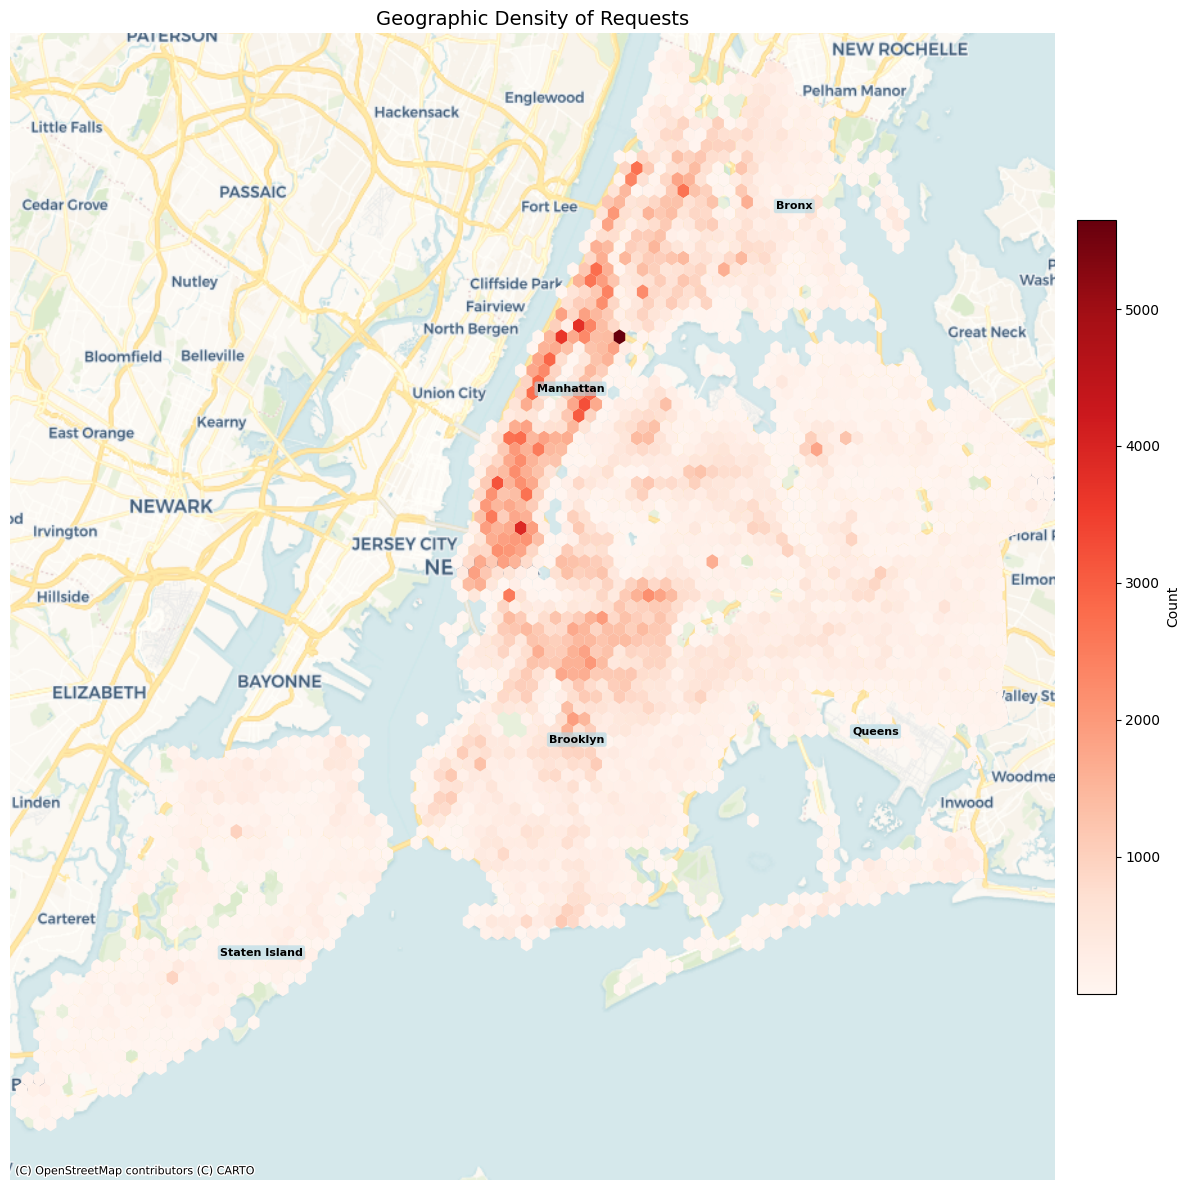

In [5]:
# Example usage with the existing data
fig, ax = plotting.create_hexbin_density_map(
    df, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Requests",
)
plt.show()


## Load Preprocessed Data

This section loads the fully preprocessed data with external datasets merged in. The preprocessing pipeline performs the following operations:

**Function:** `preprocessing.preprocess_and_merge_external_data()`

### Pipeline Steps:

#### 1. Load DOHMH Data
- Loads raw data from `config.LANDING_DATA_PATH`

#### 2. Preprocess DOHMH Data
**Date Features** (`create_date_features`):
- `day`: Date portion (no time component)
- `created_date_hour`: Rounded to hour for deduplication
- `time_to_resolution`, `time_to_resolution_hours`, `time_to_resolution_days`: Duration from created to closed
- `time_closed_to_resolution_update`, `time_closed_to_resolution_update_hours`, `time_closed_to_resolution_update_days`: Duration from closed to resolution update
- Validation flags: `is_closed_before_created`, `is_identical_created_closed`, `is_created_at_midnight`, `is_closed_at_midnight`

**Freetext Mapping** (`map_freetext_columns`):
- Maps `complaint_type` → `complaint_family` (vector_control, food_safety, air_smoke_mold, animal_control) and other derived fields
- Maps `descriptor` → standardized descriptor categories
- Maps `resolution_description` → `resolution_outcome` (inspection, duplicate_of_previous, etc.)
- Uses Excel mappings from `config.MAPPINGS_PATH`

**Filtering & Cleaning** (`filter_and_clean`):
- Remove exact duplicate records
- Remove duplicates based on `[created_date_hour, complaint_type, incident_address, borough, descriptor, resolution_description]`
- Filter out records where `is_closed_before_created == True`
- Filter to records from 2010-01-01 onwards

#### 3. Merge Census Data
**Spatial Join** (`merge_census_data`):
- Convert lat/lon to Point geometries
- Spatially join with census block groups (2022 Tiger/Line shapefiles)
- Add `GEOID` (census block group identifier)
- Merge population data by `GEOID` and `year`
- **Population Extension:** Forward-fill 2024-2025 and backfill 2010-2012 using calculated growth rates

#### 4. Merge Weather Data
**Weather Processing** (`merge_weather_data`):
- Loads NOAA nClimGrid daily weather data
- Extracts FIPS code (first 5 chars of GEOID)
- Joins by `[fips, day]`

**Unit Conversion** (`convert_weather_units`):
- Temperature: Celsius → Fahrenheit (°F = °C × 9/5 + 32)
- Precipitation: Tenths of millimeters → inches (inches = mm / 25.4)

---

**Derived Weather Features (Feature Engineering)**  
> This section is also feature engineering. It is more efficient to calculate these weather-based features on the raw weather file before merging with other datasets, rather than after merging.

| Field Name       | Definition                                      | Why / Purpose (Impact on HOHMH Service Requests)                                                        |
|-----------------|-------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| `heating_degree` | `max(0, 65 - tavg)` – heating degree days      | Colder days increase heating demand; more heating-related complaints or maintenance requests.         |
| `cooling_degree` | `max(0, tavg - 65)` – cooling degree days      | Hotter days increase cooling/AC demand; may lead to more cooling failures or related service calls.  |
| `heat_flag`      | 1 if `tmax ≥ 90°F`, else 0                     | Extreme heat days can trigger emergency service requests for cooling, ventilation, or hydration issues. |
| `freeze_flag`    | 1 if `tmin ≤ 32°F`, else 0                     | Freezing temperatures can cause pipe bursts, water damage, or other cold-related service requests.    |
| `rain_3d`        | 3-day rolling sum of precipitation (inches)    | Short-term rainfall accumulation may create standing water, increase rodent or pest activity, and generate maintenance complaints. |
| `rain_7d`        | 7-day rolling sum of precipitation (inches)    | Longer-term rainfall trends affect drainage, flooding risk, and environmental conditions that drive service requests. |


**Weather Columns Added:**
- Base: `tavg`, `tmax`, `tmin`, `prcp` (all in US units)
- Derived: `heating_degree`, `cooling_degree`, `heat_flag`, `freeze_flag`, `rain_3d`, `rain_7d`

---

### Final Output:
- Cleaned service request data with census and weather features
- All invalid/duplicate records removed
- Weather in US units (°F and inches)
- Population estimates for all years 2010-2025

In [6]:
df = preprocessing.preprocess_and_merge_external_data()

Loading DOHMH data...
Data Shape: (1029875, 27)
Preprocessing DOHMH data...
Data Shape: (929358, 44)
Merging census data...
Data Shape: (929358, 48)
Merging weather data...
Data Shape: (909090, 59)

Final Data Shape: (909090, 59)


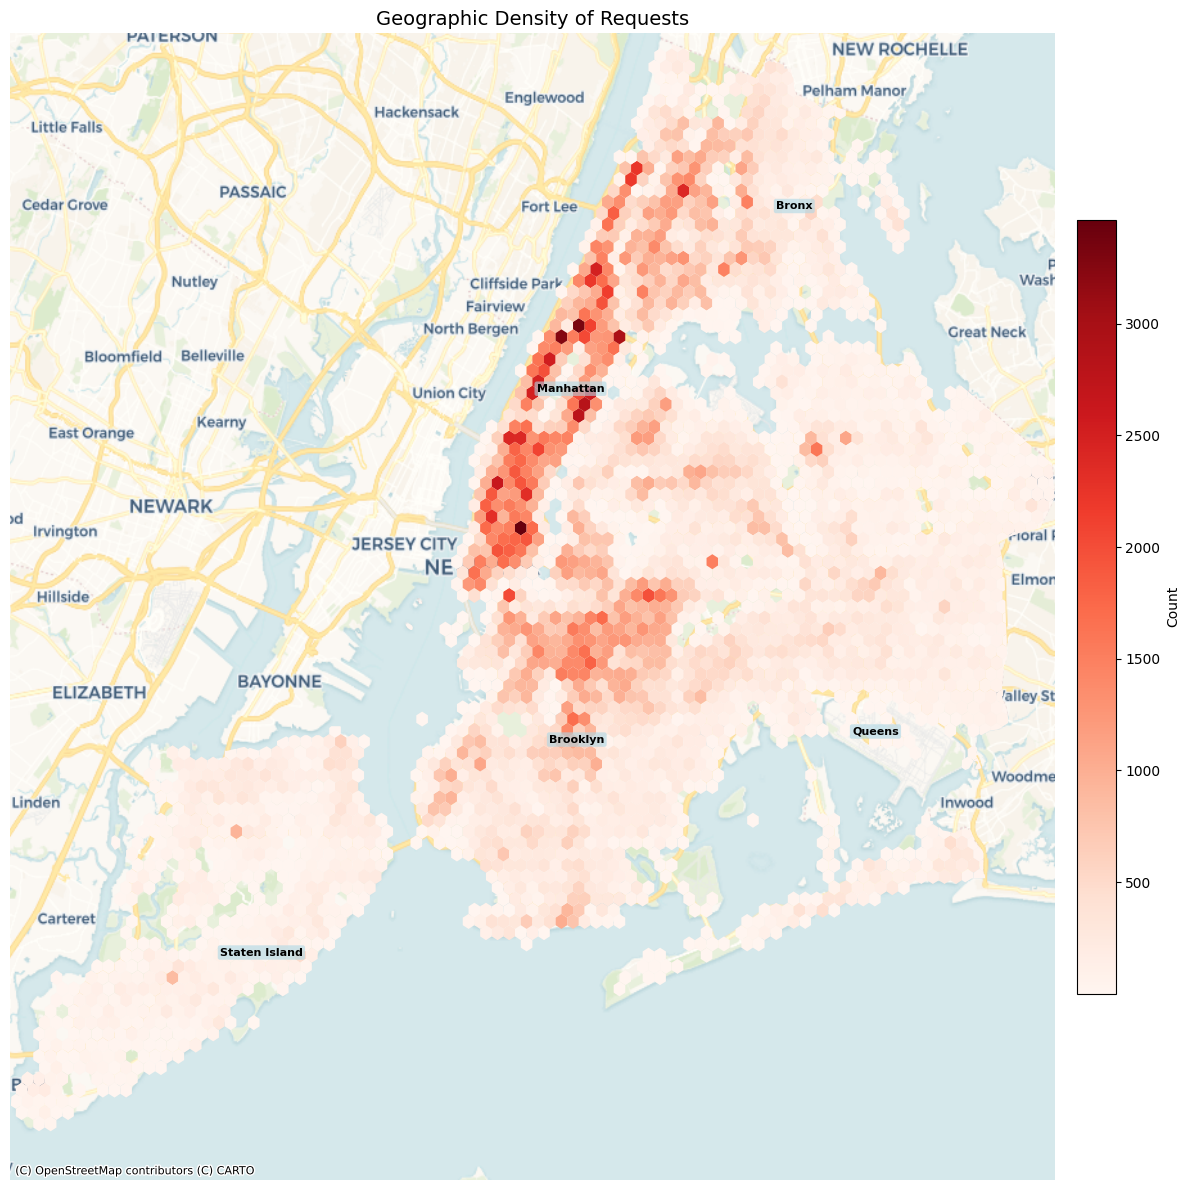

In [7]:
# Example usage with the existing data
fig, ax = plotting.create_hexbin_density_map(
    df, 
    lat_col='latitude', 
    lon_col='longitude',
    title="Geographic Density of Requests",
)
plt.show()


In [8]:
# preprocessing.save_preprocessed_data(df)

## Feature Engineering

This section builds the forecast panel using `features.build_forecast_panel()`, which transforms the preprocessed ticket-level data into a time-series panel suitable for forecasting models.

**Function:** `features.build_forecast_panel(df)`

### Overview:
Transforms ticket-level data into a sparse panel with one row per `(hex8, complaint_family, week)` combination. The target variable `y` is the count of service requests in that hex-family-week.

---

### Transformation Steps:

#### 1. Create Spatial and Temporal Keys
**H3 Hexagon Assignment:**
- `hex8`: Convert `(latitude, longitude)` → H3 hexagon at resolution 8 (~0.37 km² per hex)
- Filter out records with missing `hex8` or `complaint_family`

**Why H3?**
- H3 provides **consistent, equal-area hexagonal cells**, which makes aggregation and splitting by resolution straightforward.  
- Using `hex8` allows us to **model NYC areas efficiently**, capturing neighborhood-level variation in service requests.  
- Hexagons also make **neighboring calculations easy**, which is likely important for estimating service requests that may be spatially correlated.
- Don't have to worry about shape file boundaries


**Temporal Aggregation:**
- `week`: Convert `created_date` → ISO week starting Monday
- Aggregation level: Weekly (Monday-Sunday)

**Initial Aggregation:**
- Group by `[hex8, complaint_family, week]`
- `y`: Count of service requests (target variable)

---

#### 2. Add History Features (`add_history_features`)
Creates lag and rolling features for each `(hex8, complaint_family)` group.

**Panel Completion:**
- Generates complete weekly date range from min to max week for each group
- Fills missing weeks with `y = 0` (sparse → dense panel per group)  
> **Important:** This step carefully treats all data to prevent **data leakage** by ensuring all weeks (including those with zero requests) are represented before generating lag and rolling features. Without this, later weeks could inadvertently reference unseen future information, corrupting model training.  
**Why:** Ensures that every hex-family group has a continuous time series, which is essential for calculating lags, rolling sums, and consistent model input.

**Lag Features:**
- `lag1`: Service request count from 1 week ago  
  **Why:** Captures very short-term momentum and immediate past demand, which often drives the next week’s requests. Using a 1-week lag aligns with the natural weekly reporting cycle and avoids introducing off-week effects.
- `lag4`: Service request count from 4 weeks ago  
  **Why:** Represents roughly one month ago, capturing recurring patterns in resident behavior or reporting cycles. The 4-week lag is chosen to align with monthly rhythms while avoiding mid-month or irregular offsets.

**Rolling Window Features:**
- `roll4`: Sum of service requests over past 4 weeks (1-month rolling sum)  
  **Why:** Smooths weekly volatility and reflects short-term accumulation of service requests. A 4-week window captures monthly variation without overlapping incomplete cycles.
- `roll12`: Sum of service requests over past 12 weeks (3-month rolling sum)  
  **Why:** Captures longer-term trends and seasonal patterns across approximately one quarter. Using 12 weeks (three clean 4-week periods) avoids mid-quarter distortions and provides a stable measure of sustained changes.

**Temporal Gap Feature:**
- `weeks_since_last`: Number of weeks since last non-zero observation in this group  
  **Why:** Measures inactivity periods, helping the model distinguish between consistently active areas vs. sporadic requests.

---

#### 3. Add Momentum Feature
- `momentum = roll4 / (roll12 + 1e-6)`: Ratio of 1-month to 3-month activity  
- Captures acceleration/deceleration trends in service requests  
- Small epsilon prevents division by zero  
**Why:** Highlights areas with recent spikes or drops in service requests relative to their longer-term history. The clean 4-to-12 ratio also aligns with natural monthly and quarterly cycles, making the metric easier to interpret.

---

#### 4. Add Calendar Features
**Temporal Indicators:**
- `week_of_year`: ISO week number (1-52/53)
- `month`: Month (1-12)
- `quarter`: Quarter (1-4)

**Spatial Hierarchy:**
- `hex6`: Parent hexagon at resolution 6 (~36.13 km² per hex) - used for broader geographic labeling

**COVID Period Indicator:**
- `covid_flag`: Categorical flag ('pre', 'during', 'post')
  - `'pre'`: Before March 1, 2020
  - `'during'`: March 1, 2020 – December 31, 2021
  - `'post'`: After December 31, 2021  
**Why:** COVID-19 significantly changed the dynamics of the system during the pandemic and in the period that followed. The flag serves primarily as a **proxy for work-from-home (WFH) behavior**, which influenced where and how often residents submitted service requests. When people spend more time at home, they are more likely to **notice issues in their living environment** and therefore **submit more service requests**. The effect also persisted post-pandemic as hybrid work patterns became common.

---

#### 5. Add Neighbor Aggregates (`aggregate_on_parent`)
Aggregates activity from neighboring hexagons at resolution 7 (parent level).

**Process:**
1. Create `hex7`: Parent hexagon at resolution 7
2. Group by `[week, complaint_family, hex7]`
3. Sum `roll4` and `roll12` across all hex8s within each hex7

**New Features:**
- `nbr_roll4`: Sum of 1-month rolling activity from all neighbors in same hex7 parent
- `nbr_roll12`: Sum of 3-month rolling activity from all neighbors in same hex7 parent

**Purpose:** Captures spillover effects and broader geographic trends

---

#### 6. Merge Weather Features
Aggregates weather data to `[hex8, complaint_family, week]` level by taking the **mean** of daily weather values within each week.

**Weather Features Merged:**
- **Base Temperature:** `tavg`, `tmax`, `tmin` (°F)
- **Precipitation:** `prcp` (inches per day)
- **Degree Days:** `heating_degree`, `cooling_degree` (base 65°F)
- **Extreme Flags:** `heat_flag` (tmax ≥ 90°F), `freeze_flag` (tmin ≤ 32°F)
- **Rolling Precipitation:** `rain_3d`, `rain_7d` (3-day and 7-day cumulative inches)

**Aggregation Method:** Mean across days within the week

---

#### 7. Merge Population Features
Aggregates population data to hex8 level.

**Process:**
1. Group by `[hex8, GEOID]` and take first population value
2. Sum population across all GEOIDs within each hex8
3. Create `pop_hex`: Total population in the hexagon
4. Fill missing values with 0

**Derived Feature:**
- `log_pop = log(max(pop_hex, 1))`: Log-transformed population to handle scale and zero values

---

### Final Output Schema:

**28 columns total:**

**Keys (4):**
- `hex8`: H3 hexagon at resolution 8
- `hex6`: H3 hexagon at resolution 6 (parent)
- `complaint_family`: Complaint category
- `week`: Week starting Monday

**Target (1):**
- `y`: Service request count

**Calendar (3):**
- `week_of_year`, `month`, `quarter`

**History Features (6):**
- `lag1`, `lag4`: Lag features
- `roll4`, `roll12`: Rolling sums
- `momentum`: Roll4/Roll12 ratio
- `weeks_since_last`: Gap since last activity

**Weather (10):**
- `tmin`, `tmax`, `tavg`, `prcp`
- `heating_degree`, `cooling_degree`
- `heat_flag`, `freeze_flag`
- `rain_3d`, `rain_7d`

**Population (1):**
- `log_pop`: Log-transformed hexagon population

**Neighbor Aggregates (2):**
- `nbr_roll4`, `nbr_roll12`: Neighbor activity sums

**COVID Period (1):**
- `covid_flag`: COVID period indicator

---

### Key Design Principles:

1. **Leakage Prevention:** All lag/rolling features use only past data
2. **Sparse Panel:** Only keeps weeks with actual observations (`y > 0`)
3. **Geographic Hierarchy:** Uses H3 hexagons at multiple resolutions for spatial features
4. **Temporal Granularity:** Weekly aggregation balances signal and noise
5. **External Data:** Weather and population provide context for demand patterns

# Step 4 - Feature Engineering

This notebook transforms preprocessed ticket-level service request data into a time-series forecast panel suitable for machine learning models. 

### Key Objectives:
1. **Spatial Aggregation**: Convert lat/lon coordinates to H3 hexagons (resolution 8) for consistent geographic units
2. **Temporal Aggregation**: Aggregate service requests to weekly granularity (Monday-Sunday)
3. **Panel Structure**: Create sparse panel with one row per `(hex8, complaint_family, week)` combination
4. **Feature Engineering**: Build predictive features including:
   - **History Features**: Lags (1, 4 weeks) and rolling sums (4, 12 weeks)
   - **Momentum Features**: Ratio of short-term to long-term activity
   - **Calendar Features**: Week of year, month, quarter
   - **Neighbor Features**: Aggregate activity from nearby hexagons
   - **Weather Features**: Temperature, precipitation, degree days, extreme weather flags
   - **Population Features**: Log-transformed population density
   - **COVID Indicator**: Period flags (pre/during/post COVID-19)

### Data Flow:
```
Raw DOHMH Data (1M+ tickets)
    ↓
Preprocessed Data with Census + Weather (~900K tickets)
    ↓
Forecast Panel (~550K hex-family-week observations)
    ↓
28 engineered features + target variable (y = count)
```

### Output:
A sparse time-series panel ready for training forecasting models, with leakage-safe features that only use information available at prediction time.


In [9]:
forecast_panel = features.build_forecast_panel(df)
print(forecast_panel.shape)

c:\Users\gorav\GitHub\nyc-311-service-requests\src\features.py:144: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby(["hex8", "complaint_family"], group_keys=False).apply(


(547535, 28)


In [ ]:
# features.save_forecast_panel_data(forecast_panel)

### Target

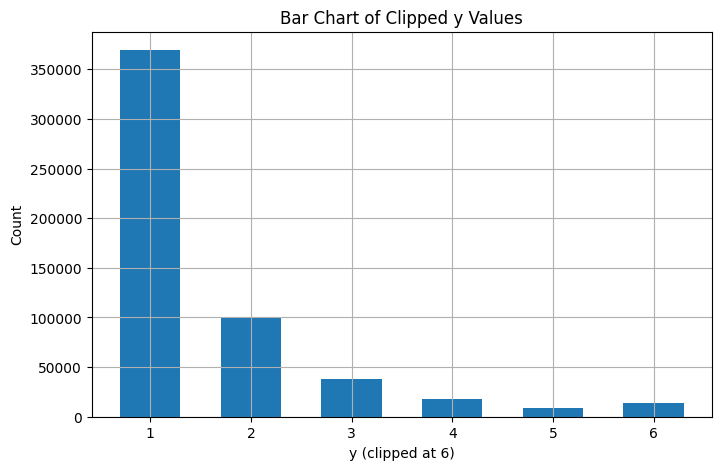

In [11]:
counts = forecast_panel['y'].clip(upper=6).value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values, width=0.6)
plt.xlabel('y (clipped at 6)')
plt.ylabel('Count')
plt.title('Bar Chart of Clipped y Values')
plt.xticks(counts.index)
plt.grid()
plt.show()

### Categorical Features

In [12]:
reload(config)

<module 'src.config' from 'c:\\Users\\gorav\\GitHub\\nyc-311-service-requests\\src\\config.py'>

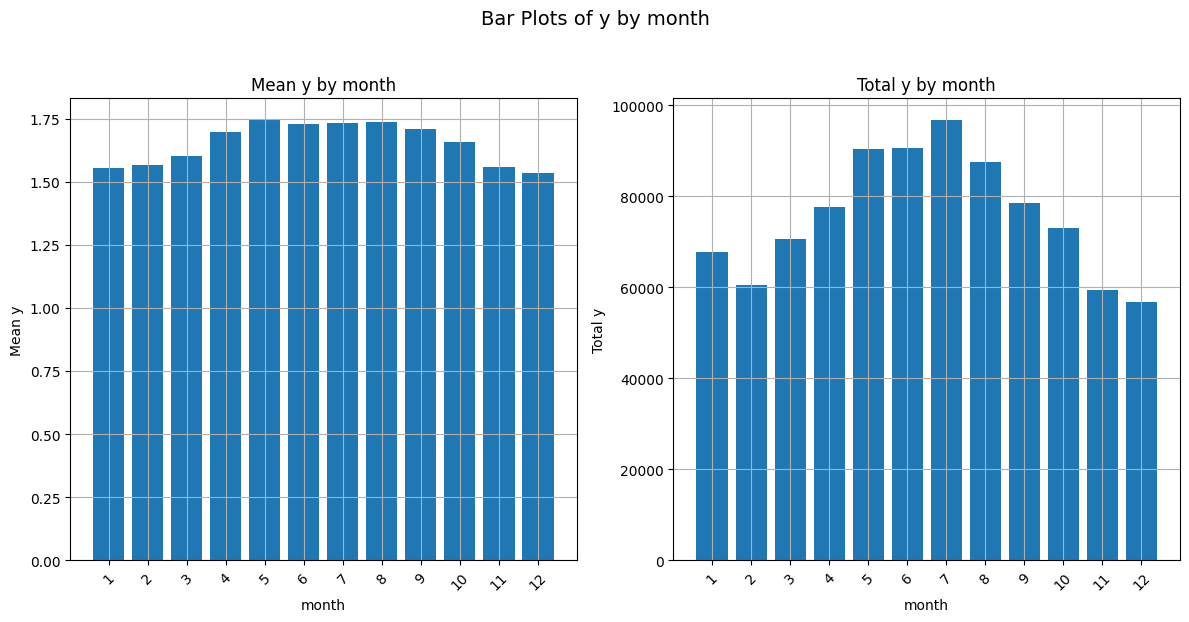

----------------------------------------------------------------------------------------------------


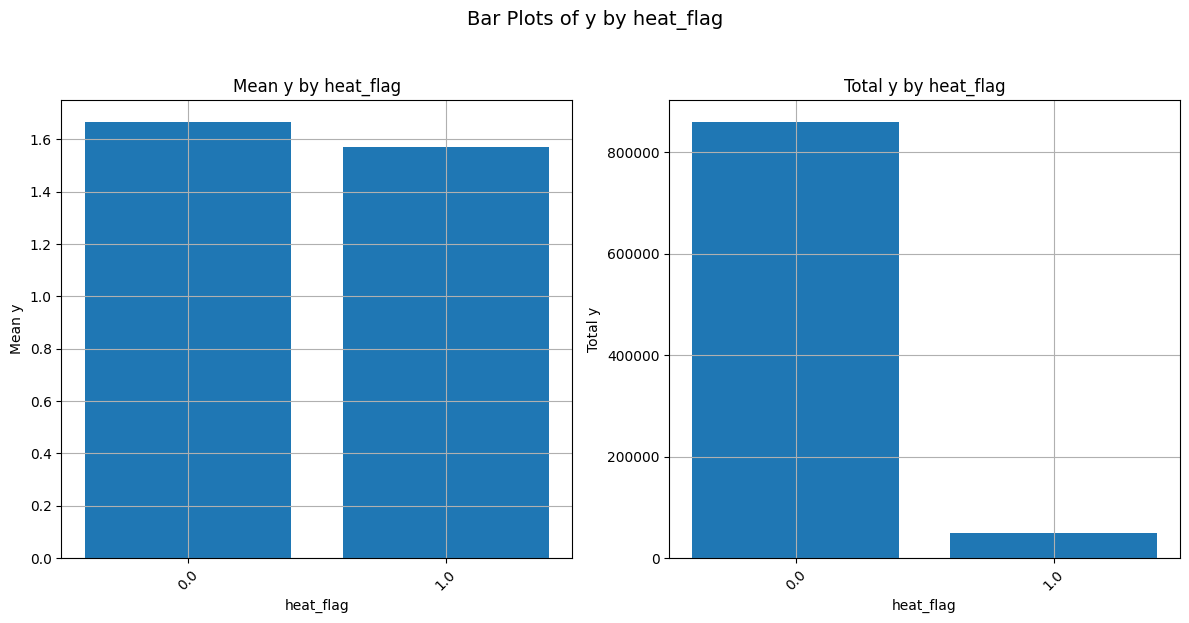

----------------------------------------------------------------------------------------------------


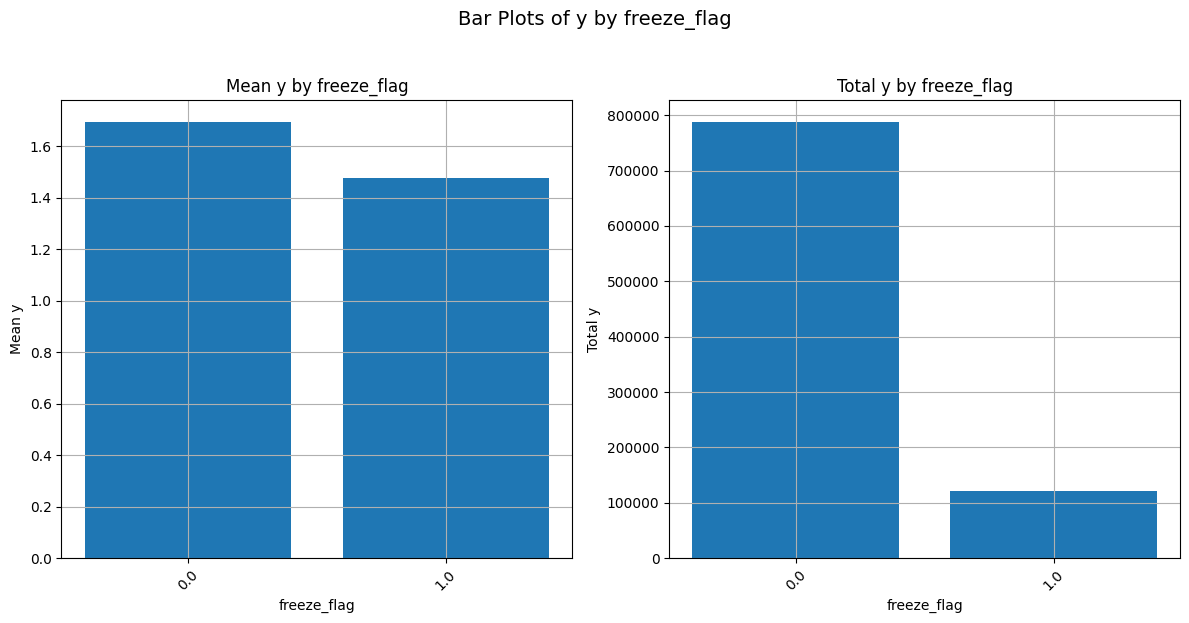

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


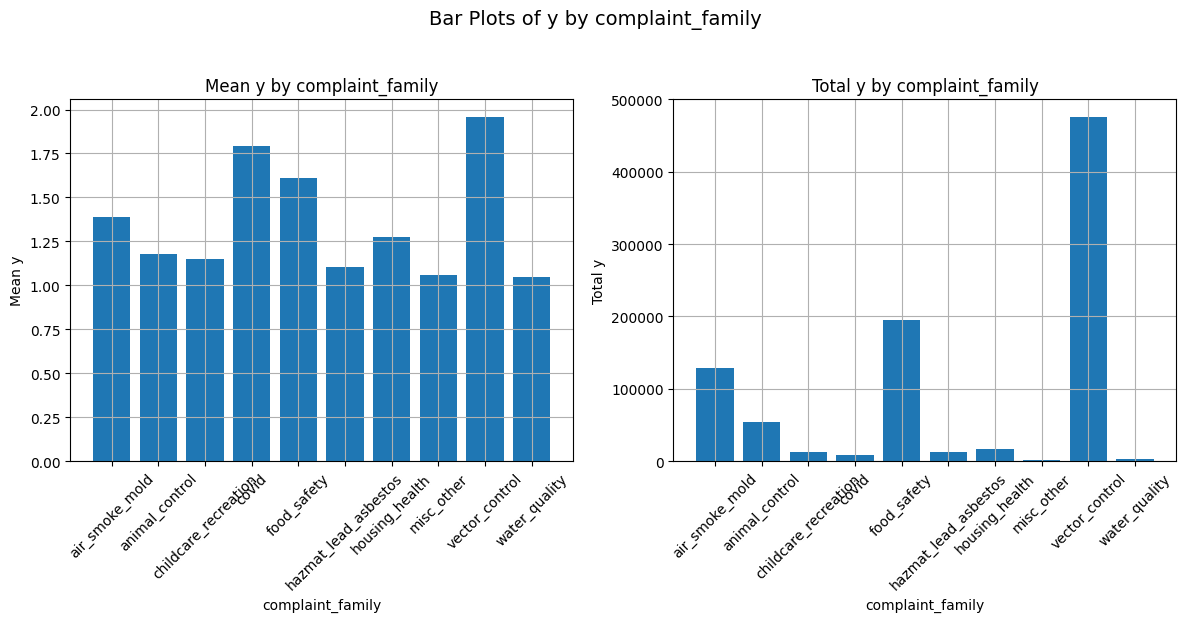

----------------------------------------------------------------------------------------------------


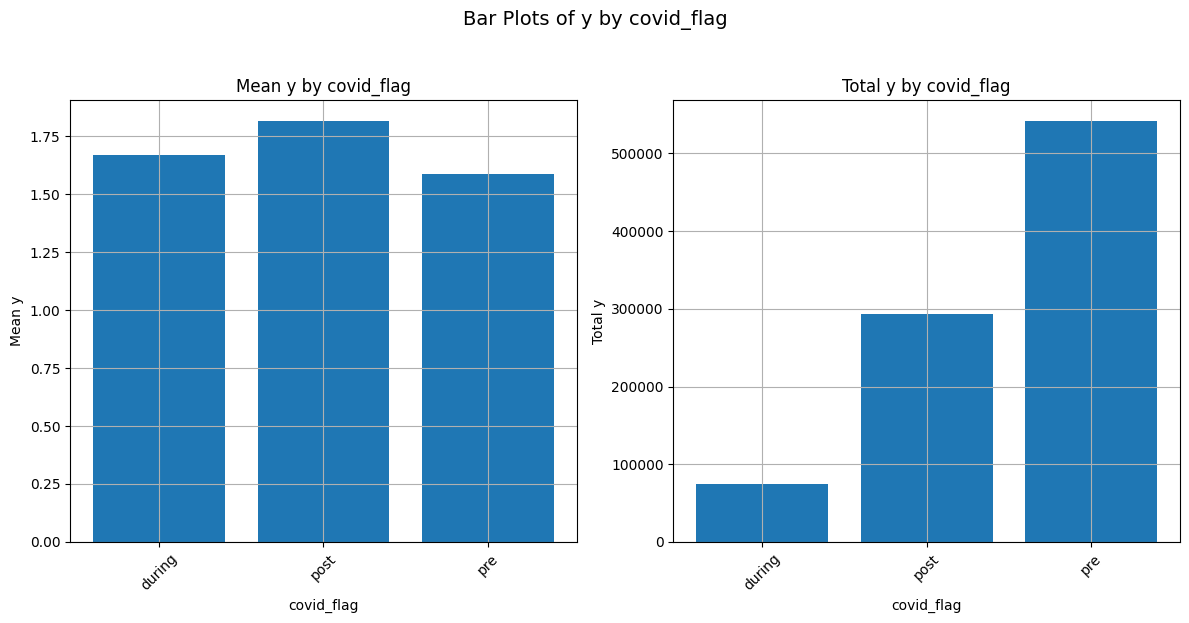

----------------------------------------------------------------------------------------------------


In [13]:
for i in config.CATEGORICAL_COLUMNS:
    if i != 'hex6':
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # --- Mean y by category ---
        means = forecast_panel.groupby(i)['y'].mean().sort_index()
        axes[0].bar(means.index.astype(str), means.values)
        axes[0].set_title(f'Mean y by {i}')
        axes[0].set_xlabel(i)
        axes[0].set_ylabel('Mean y')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid()

        # --- Total y by category ---
        sums = forecast_panel.groupby(i)['y'].sum().sort_index()
        axes[1].bar(sums.index.astype(str), sums.values)
        axes[1].set_title(f'Total y by {i}')
        axes[1].set_xlabel(i)
        axes[1].set_ylabel('Total y')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid()


        plt.suptitle(f'Bar Plots of y by {i}', fontsize=14, y=1.03)
        plt.tight_layout()
        plt.show()
    print('-'*100)


#### Covid Flag

In [14]:
# Plot counts over time by year-month
df_plot = forecast_panel.copy()
df_plot['year_month'] = df_plot['week'].dt.to_period('M')

# Add covid_flag to monthly aggregation
monthly_counts = df_plot.groupby(['year_month', 'covid_flag'])['y'].sum().reset_index()
monthly_counts = monthly_counts.groupby('year_month').agg({
    'y': 'sum',
    'covid_flag': 'first'  # Take the first covid_flag for each month
}).reset_index()

monthly_counts['y_smoothed'] = monthly_counts['y'].rolling(12).mean()

# Convert year_month to string for plotting
monthly_counts['year_month_str'] = monthly_counts['year_month'].astype(str)

# Define colors for covid periods
color_map = {
    'pre': 'blue',
    'during': 'red', 
    'post': 'green'
}

# Create plotly figure
fig = go.Figure()

# Add actual counts colored by covid_flag
for covid_period in ['pre', 'during', 'post']:
    period_data = monthly_counts[monthly_counts['covid_flag'] == covid_period]
    if not period_data.empty:
        fig.add_trace(go.Scatter(
            x=period_data['year_month_str'],
            y=period_data['y'],
            mode='lines+markers',
            name=f'Monthly Counts ({covid_period.title()} COVID)',
            line=dict(color=color_map[covid_period]),
            marker=dict(size=4, color=color_map[covid_period])
        ))

# Add smoothed line
fig.add_trace(go.Scatter(
    x=monthly_counts['year_month_str'],
    y=monthly_counts['y_smoothed'],
    mode='lines',
    name='12-Month Rolling Average',
    line=dict(color='black', width=2, dash='dash')
))

# Update layout
fig.update_layout(
    title='Monthly Counts Over Time (Colored by COVID Period)',
    xaxis_title='Year-Month',
    yaxis_title='Count',
    width=1200,
    height=600,
    showlegend=True,
    xaxis=dict(tickangle=45),
    grid=dict(rows=1, columns=1)
)

fig.show()

### Numerical Features

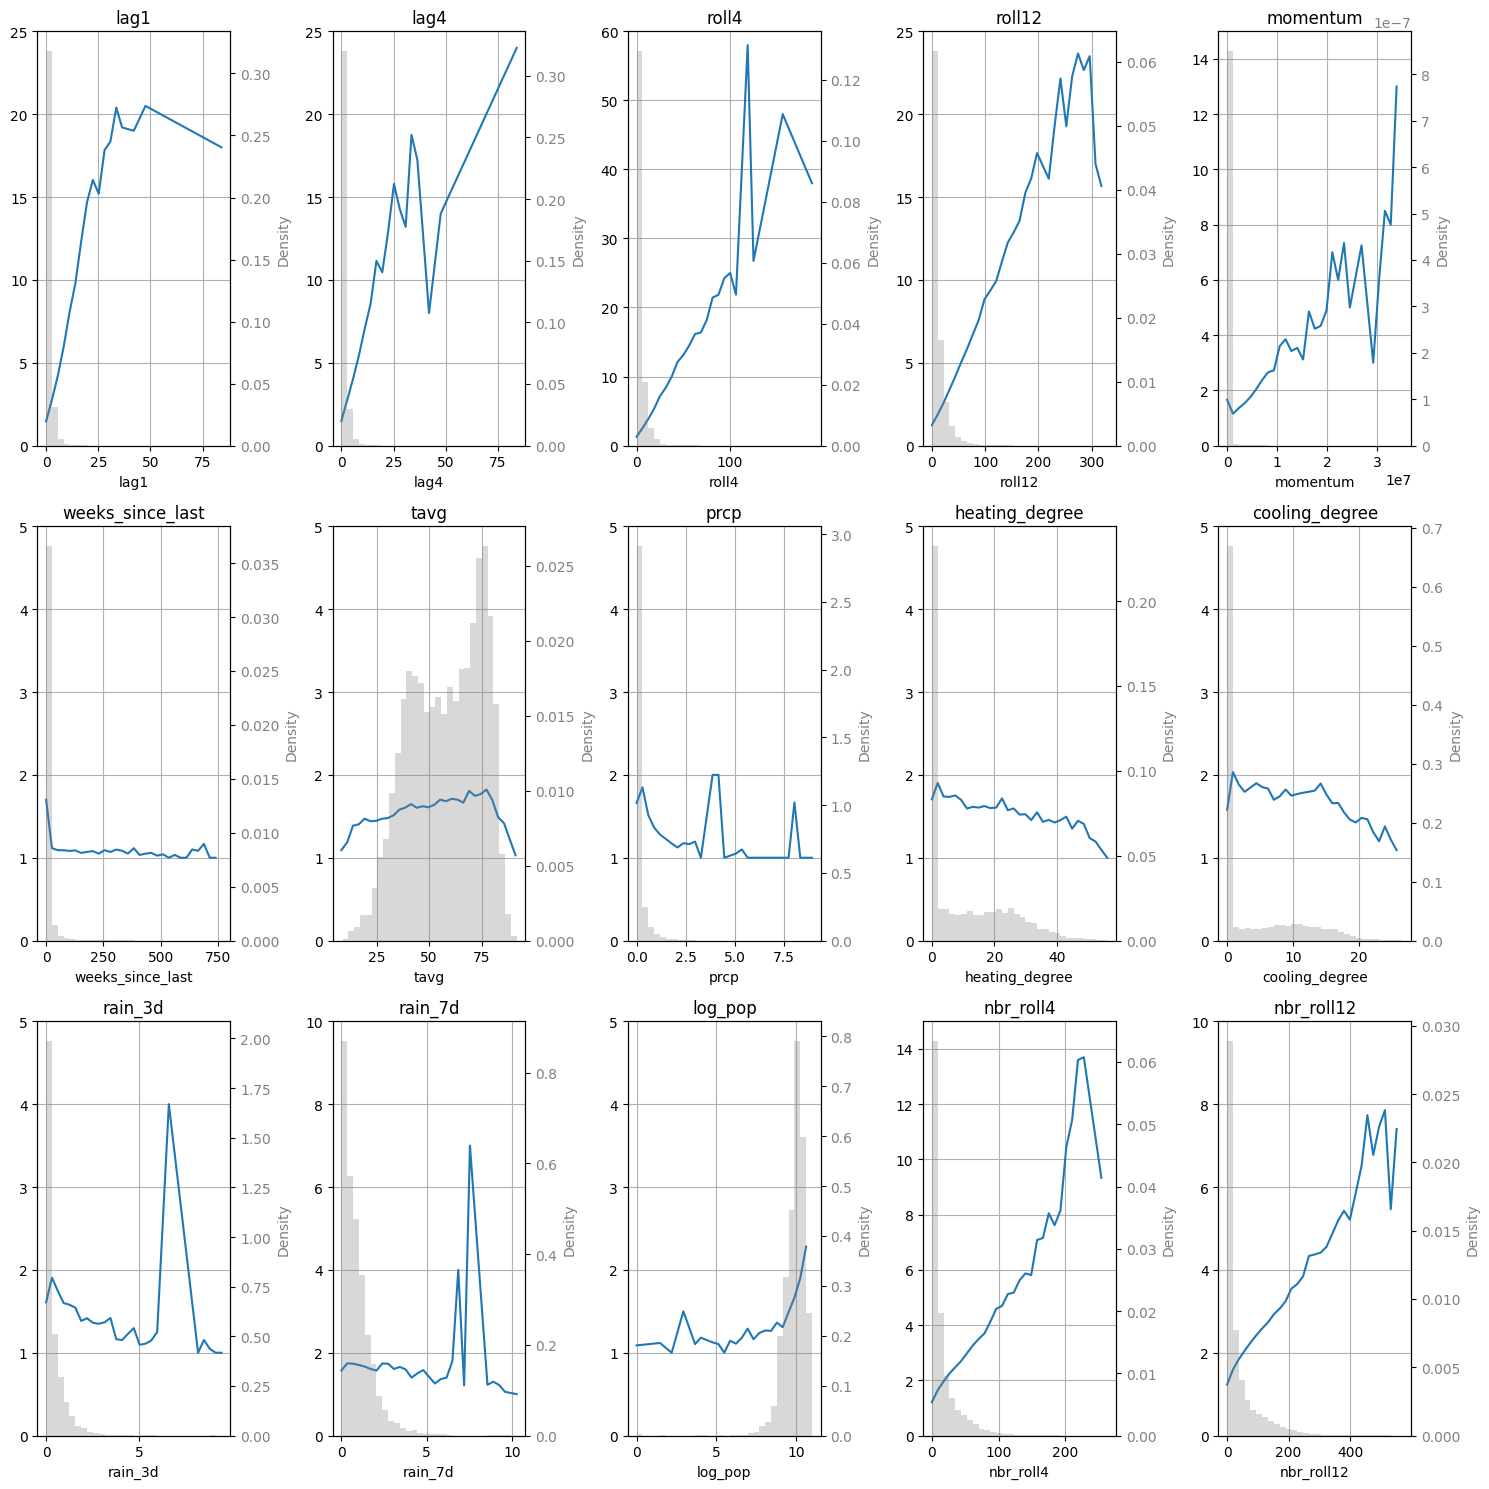

In [15]:
num_cols = len(config.NUMERICAL_COLUMNS)

# Define subplot grid
ncols = 5  # number of columns in the subplot grid (you can adjust)
nrows = int(np.ceil(num_cols / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten to easily iterate over axes

for idx, i in enumerate(config.NUMERICAL_COLUMNS):
    if i in ['heat_flag', 'freeze_flag']:
        gap = 1
    else:
        gap = (forecast_panel[i].max() - forecast_panel[i].min()) / 30
    ax = axes[idx]
    
    # Create secondary axis for histogram
    ax2 = ax.twinx()
    
    # Plot histogram on secondary axis in light grey
    ax2.hist(forecast_panel[i], bins=30, alpha=0.3, color='grey', density=True)
    ax2.set_ylabel('Density', color='grey')
    ax2.tick_params(axis='y', labelcolor='grey')
    
    # Plot mean values on primary axis
    df_temp = forecast_panel.groupby(forecast_panel[i] // gap * gap)['y'].mean()
    df_temp.plot(ax=ax)
    ax.grid()
    ax.set_title(i)
    max_val = df_temp.max()
    ylim_max = int(np.ceil(max_val / 5) * 5)
    ax.set_ylim(0, ylim_max)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()